# Proudění dýzou s proměnným průřezem

In [1]:
using PyPlot

In [2]:
A(x) = 1 + (x-0.5)^2;

In [3]:
const κ = 1.4;

In [4]:
density(W) = W[1];
velocity(W) = W[2]/W[1];
total_energy(W) = W[3]/W[1];
pressure(W) = (κ-1)*(W[3] - 0.5*W[2]^2/W[1]);

In [5]:
sound_speed(W) = sqrt(κ*pressure(W)/density(W));

Mach(W) = velocity(W)/sound_speed(W);

function eigen(W)
    a = sound_speed(W)
    u = velocity(W)
    return [u-a, u, u+a]
end;

function spectral_radius(W)
    a = sound_speed(W)
    u = velocity(W)
    return abs(u) + a
end;

function flux(W)
    ρ = density(W)
    u = velocity(W)
    p = pressure(W)
    H = total_energy(W) + p/ρ
    return [ρ*u, ρ*u^2+p, ρ*H*u]
end;

In [6]:
function HLL(Wl, Wr)
    σl = eigen(Wl)
    σr = eigen(Wr)
    sl = min(σl[1],σr[1])
    sr = max(σl[end],σr[end])
    
    if 0<=sl
        return flux(Wl)
    elseif 0.0<sr
        return (sr*flux(Wl) - sl*flux(Wr) + sl*sr*(Wr - Wl))/(sr - sl)
    else
        return flux(Wr)
    end
end;

In [7]:
function inlet(W)
    p_tot = 1.e5
    ρ_tot =1.2
    
    p = pressure(W)
    p = min(p, p_tot)
    M2 = 2/(κ-1)*((p/p_tot)^((1-κ)/κ) - 1)
    ρ = ρ_tot * (1 + (κ - 1)/2*M2)^(1/(1-κ))
    u  = sqrt(M2*κ*p/ρ)
    ρE  = p/(κ - 1) + 0.5*ρ*u^2
    
    return [ρ, ρ*u, ρE]
end;

In [8]:
function outlet(W)
    p2   = 0.8 * 1.e5
    ρE  = p2/(κ-1) + 0.5*density(W)*velocity(W)^2
    
    return [W[1], W[2], ρE]
end;

In [9]:
function initial_condition(n)
    W = zeros(3,n)
    for i=1:n
        W[1,i] = 1.0
        W[2,i] = 0.0
        W[3,i] = 1.e5/(κ - 1)
    end
    return W
end;

In [10]:
function reziduum1(W, Flux)
    n = size(W,2)
    Δx = 1.0/n
    F = zeros(3,n+1)
    
    F[:,1] = A(0.0)*Flux(inlet(W[:,1]), W[:,1])
    F[:,n+1] = A(1.0)*Flux(W[:,n], outlet(W[:,n]))
    for i=2:n
        x = (i-1)*Δx
        F[:,i] = A(x)*Flux(W[:,i-1], W[:,i])
    end
    
    rez = zeros(3,n)
    for i=1:n
        p = pressure(W[:,i])
        x = (i-0.5)*Δx
        Ax = (A(x+Δx/2) - A(x-Δx/2))/Δx
        Q = [0.0, p*Ax, 0.0]
        rez[:,i] = 1/(A(x)*Δx)*(F[:,i+1] - F[:,i]) - Q/A(x)
    end
    return rez
end;

In [11]:
function solve1(W0, R, Flux)
    iters = 20000
    history = zeros(iters,1)
    n = size(W0,2)
    Δx = 1.0 / n
    W = copy(W0)
    
    for iter=1:iters
        Δt = 0.8*Δx/maximum([spectral_radius(W[:,i]) for i=1:n])
        r = R(W, Flux)
        W -= Δt*r
    
        history[iter] = sqrt(sum(r[1,:].^2))
    end
    
    return W, history
end;

In [12]:
n = 50;
Δx = 1.0 / n;
x=range(Δx/2, step=Δx, length=n);

In [13]:
W0 = initial_condition(n);

In [14]:
W1, history1 = solve1(W0, reziduum1, HLL);

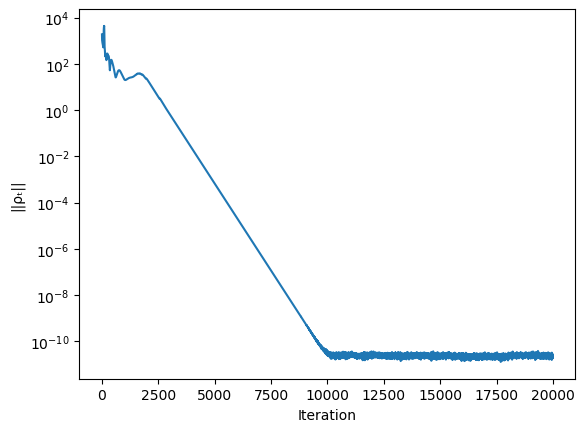

In [15]:
semilogy(history1, label="HLL, 1st order");
xlabel("Iteration"); ylabel("||ρₜ||");

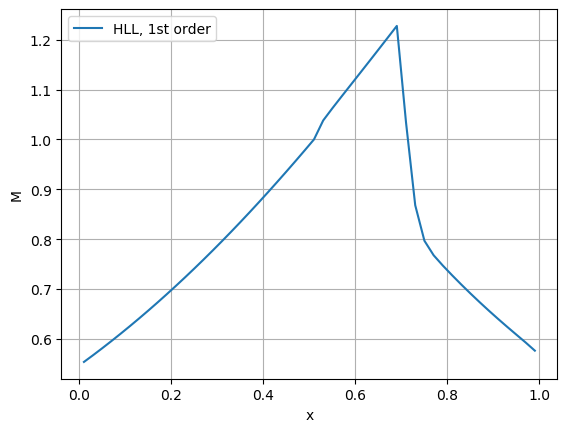

In [16]:
plot(x, [Mach(W1[:,i]) for i=1:n], label="HLL, 1st order");
xlabel("x"); ylabel("M");
legend(loc="upper left");
grid(true);

In [17]:
function Rusanov(Wl, Wr)
    Fl = flux(Wl)
    Fr = flux(Wr)
    s = max( spectral_radius(Wl), spectral_radius(Wr) )
    
    return (Fl + Fr)/2.0 - s/2.0*(Wr - Wl)
end;

In [18]:
W1ru, history1ru = solve1(W0, reziduum1, Rusanov);

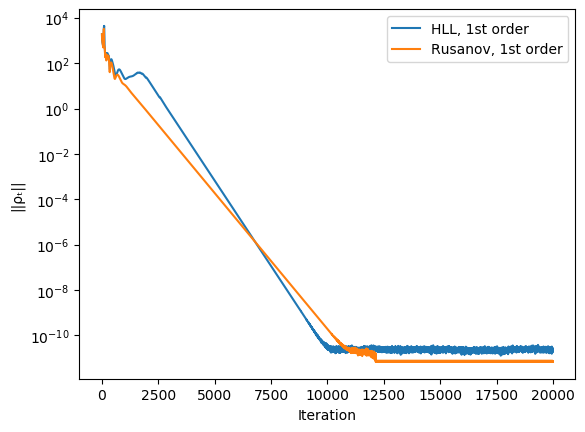

In [19]:
semilogy(history1, label="HLL, 1st order");
semilogy(history1ru, label="Rusanov, 1st order");
legend(loc="upper right")
xlabel("Iteration"); ylabel("||ρₜ||");

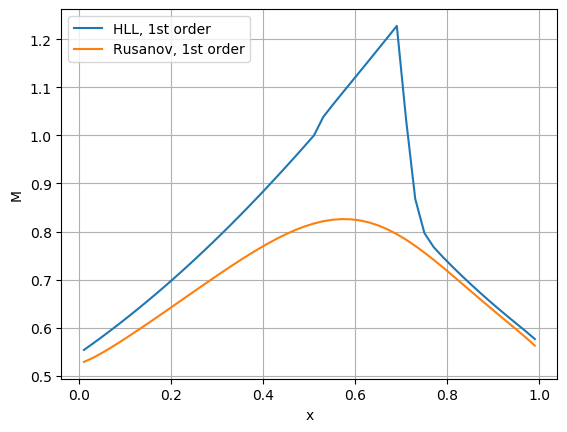

In [20]:
plot(x, [Mach(W1[:,i]) for i=1:n], label="HLL, 1st order");
plot(x, [Mach(W1ru[:,i]) for i=1:n], label="Rusanov, 1st order");
xlabel("x"); ylabel("M");
legend(loc="upper left");
grid(true);

In [21]:
nf  = 200
Δxf = 1.0 / nf
xf  = range(Δxf/2, step=Δxf, length=nf)
W0f = initial_condition(nf);

In [22]:
W1ruf, history1ruf = solve1(W0f, reziduum1, Rusanov);

In [23]:
W1f, history1f = solve1(W0f, reziduum1, HLL);

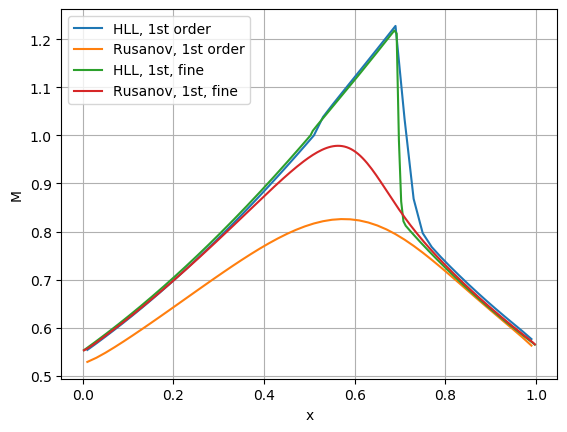

In [24]:
plot(x, [Mach(W1[:,i]) for i=1:n], label="HLL, 1st order");
plot(x, [Mach(W1ru[:,i]) for i=1:n], label="Rusanov, 1st order");
plot(xf, [Mach(W1f[:,i]) for i=1:nf], label="HLL, 1st, fine");
plot(xf, [Mach(W1ruf[:,i]) for i=1:nf], label="Rusanov, 1st, fine");
xlabel("x"); ylabel("M");
legend(loc="upper left");
grid(true);

## Schéma druhého řádu přesnosti

In [25]:
function reziduum2(W, Flux)
    n = size(W,2)
    Δx = 1.0 / n
    
    F = zeros(3,n+1)
    
    ΔW = copy(W)
    ΔW[:,1]  = W[:,2] - W[:,1]
    ΔW[:,n] = W[:,n] - W[:,n-1]
    
    for i=2:n-1
        for k=1:size(W,1)
            
            if (W[k,i]-W[k,i-1])*(W[k,i+1]-W[k,i]) <= 0
                ΔW[k,i] = 0.0
            elseif abs(W[k,i]-W[k,i-1]) < abs(W[k,i+1]-W[k,i])
                ΔW[k,i] = W[k,i]-W[k,i-1]
            else
                ΔW[k,i] = W[k,i+1]-W[k,i]
            end
        end
    end
    
    F[:,1]  = A(0.0) * Flux( inlet(W[:,1]), W[:,1])
    F[:,n+1] = A(1.0) * Flux( W[:,n], outlet(W[:,n]))
    
    for i=2:n
        x = (i-1)*Δx
        F[:,i] = A(x) * Flux(W[:,i-1] .+ ΔW[:,i-1]/2, W[:,i] .- ΔW[:,i]/2 )
    end
                
    rez = zeros(3,n)
    for i=1:n
        x = (i - 0.5)*Δx
        Ax = (A(x+Δx/2) - A(x-Δx/2))/Δx
                    
        p = pressure(W[:,i])
        Q = [ 0.0, p*Ax, 0.0 ]
        rez[:,i] = (F[:,i+1] - F[:,i])/(Δx*A(x))  - Q/A(x)
    end
    return rez
end;

In [26]:
function solve2(W0, R, Flux)
    iters = 20000
    history = zeros(iters)
    n = size(W0,2)
    Δx = 1.0 / n
    W  = copy(W0)
    Wp = copy(W0)
    
    for iter=1:iters
        dt = 0.8*Δx/maximum([spectral_radius(W[:,i]) for i=1:n])
    
        r = R(W, Flux)
        Wp = W - dt*r
    
        r = (r + R(Wp, Flux)) / 2.0
        W -= dt*r 
        history[iter] = sqrt(sum(r[1,:].^2))
    end
    return W, history
end;

In [27]:
W2, history2 = solve2(W0, reziduum2, HLL);

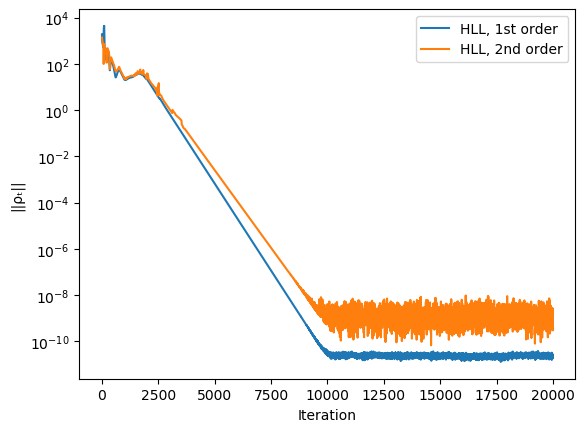

In [28]:
semilogy(history1, label="HLL, 1st order");
semilogy(history2, label="HLL, 2nd order");
legend(loc="upper right")
xlabel("Iteration"); ylabel("||ρₜ||");

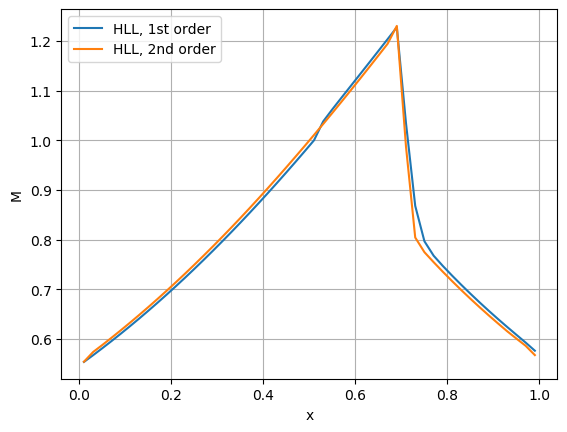

In [29]:
plot(x, [Mach(W1[:,i]) for i=1:n], "-", label="HLL, 1st order");
plot(x, [Mach(W2[:,i]) for i=1:n], "-", label="HLL, 2nd order");
xlabel("x"); ylabel("M");
legend(loc="upper left");
grid(true);

In [30]:
W2ru, history2ru = solve2(W0, reziduum2, Rusanov);

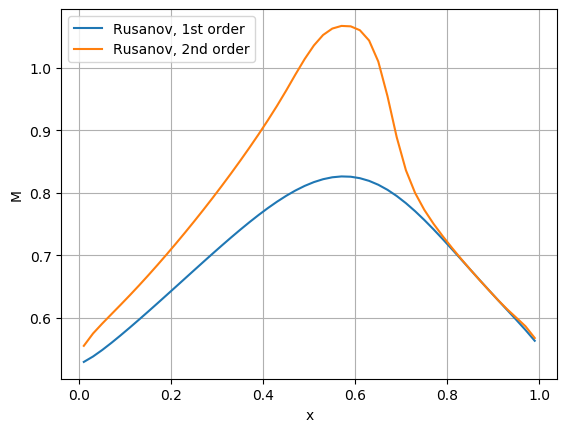

In [31]:
plot(x, [Mach(W1ru[:,i]) for i=1:n], label="Rusanov, 1st order");
plot(x, [Mach(W2ru[:,i]) for i=1:n], label="Rusanov, 2nd order");
xlabel("x"); ylabel("M");
legend(loc="upper left");
grid(true);

In [32]:
W2ruf, history2ruf = solve2(W0f, reziduum2, Rusanov);

In [33]:
W2f, history2f = solve2(W0f, reziduum2, HLL);

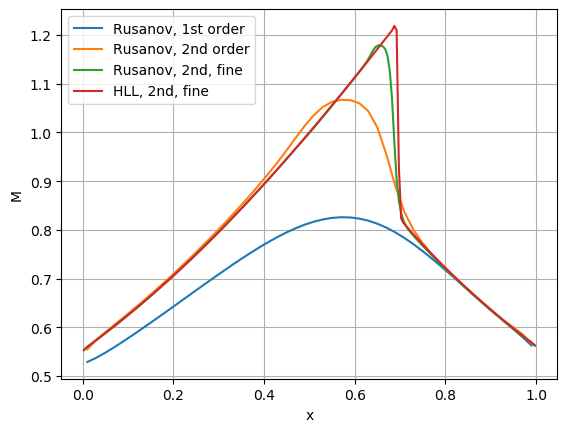

In [34]:
plot(x, [Mach(W1ru[:,i]) for i=1:n], label="Rusanov, 1st order");
plot(x, [Mach(W2ru[:,i]) for i=1:n], label="Rusanov, 2nd order");
plot(xf, [Mach(W2ruf[:,i]) for i=1:nf], label="Rusanov, 2nd, fine");
plot(xf, [Mach(W2f[:,i]) for i=1:nf], label="HLL, 2nd, fine");
xlabel("x"); ylabel("M");
legend(loc="upper left");
grid(true);

## Prubehy entropie a celkoveho tlaku

In [35]:
entropy(W) = log(pressure(W)/density(W)^κ);

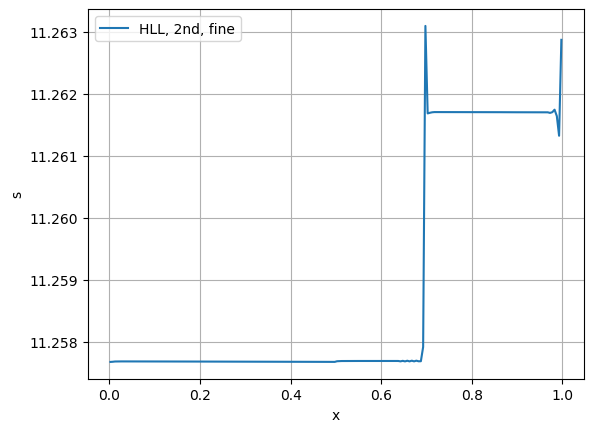

In [39]:
plot(xf, [entropy(W2f[:,i]) for i=1:nf], label="HLL, 2nd, fine");
xlabel("x"); ylabel("s");
legend(loc="upper left");
grid(true);

In [ ]:
total_pressure(W) = pressure(W)*(1+(κ-1)/2*Mach(W)^2)^(κ;